In [ ]:
import pandas as pd
import re
from gensim.models import Word2Vec
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models.callbacks import CallbackAny2Vec

# Load training data
train_data = pd.read_csv('train.csv')

# Combine Title and Body
train_data['Combined'] = train_data['Title'].fillna('') + ' ' + train_data['Body'].fillna('')

# Preprocessing function
def preprocess_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Tokenize and remove stopwords
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Preprocess Combined column
train_data['Processed'] = train_data['Combined'].apply(preprocess_text)

# Prepare sentences for Word2Vec
sentences = train_data['Processed'].tolist()

# Define a callback class for logging losses
class LossLogger(CallbackAny2Vec):
    """Logs the loss at each epoch."""
    def __init__(self):
        self.epoch = 0
        self.losses = []

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        self.losses.append(loss)
        print(f"Epoch {self.epoch + 1}, Loss: {loss}")
        self.epoch += 1

# Instantiate the logger
loss_logger = LossLogger()

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=sentences,
                          vector_size=300,  # Increased vector size
                          window=10,        # Increased window size
                          min_count=2,      # Lowered min count
                          workers=4,        # Number of threads
                          sg=1,             # Skip-gram model
                          epochs=20,        # Increased epochs
                          compute_loss=True, # Enable loss computation
                          callbacks=[loss_logger])

# Save the model
word2vec_model.save("optimized_word2vec_model.model")



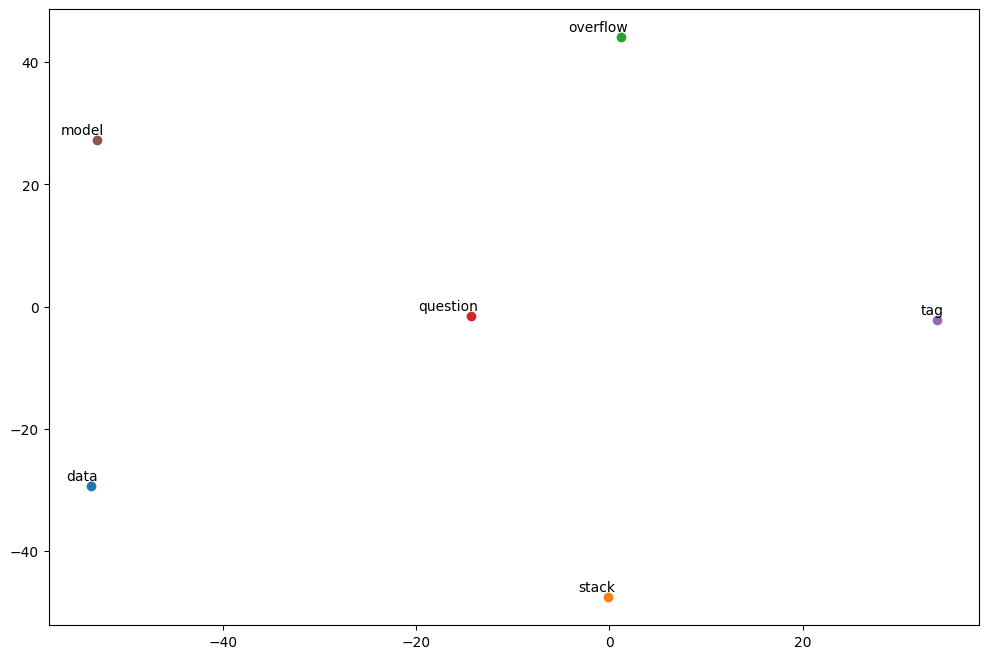

                                                   Title  Similarity
17658           Gensim word2vec in python3 missing vocab    0.833234
32346  In spacy, how to use your own word2vec model c...    0.826654
17381  Interpreting negative Word2Vec similarity from...    0.790474
22971    Using a Word2Vec model pre-trained on wikipedia    0.770298
16577  How to check the weights after every epoc in K...    0.746575


In [6]:
# Visualize word embeddings
def visualize_embeddings(word2vec_model, words):
    word_vectors = np.array([word2vec_model.wv[word] for word in words if word in word2vec_model.wv])
    labels = [word for word in words if word in word2vec_model.wv]

    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(word_vectors) - 1))

    reduced_vectors = tsne.fit_transform(word_vectors)

    plt.figure(figsize=(12, 8))
    for i, label in enumerate(labels):
        x, y = reduced_vectors[i, 0], reduced_vectors[i, 1]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.show()

# Select a sample of words for visualization
sample_words = ["data", "stack", "overflow", "question", "tag", "model"]
visualize_embeddings(word2vec_model, sample_words)

# Save document vectors
def generate_document_vectors(data, model):
    document_vectors = []
    for tokens in data['Processed']:
        vectors = [model.wv[word] for word in tokens if word in model.wv]
        if vectors:
            document_vectors.append(np.mean(vectors, axis=0))
        else:
            document_vectors.append(np.zeros(model.vector_size))
    return np.array(document_vectors)

train_doc_vectors = generate_document_vectors(train_data, word2vec_model)

# Save document vectors for later use
np.save("train_doc_vectors.npy", train_doc_vectors)

# Compute cosine similarity (example)
def compute_cosine_similarity(doc_vectors, query_vector):
    similarities = cosine_similarity([query_vector], doc_vectors)
    return similarities

# Example query
query = "How to train a Word2Vec model?"
query_tokens = preprocess_text(query)
query_vector = np.mean([word2vec_model.wv[word] for word in query_tokens if word in word2vec_model.wv], axis=0)
similarities = compute_cosine_similarity(train_doc_vectors, query_vector)

# Retrieve top-5 similar documents
train_data['Similarity'] = similarities[0]
most_similar = train_data.sort_values(by='Similarity', ascending=False).head(5)
print(most_similar[['Title', 'Similarity']])